In [49]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib notebook

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [10]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [11]:
import warnings
warnings.filterwarnings('ignore')

## Setup

In [12]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [13]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [14]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [15]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [16]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Loading

In [6]:
%%file load_blockwise.py

audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    h_target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()            
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_target.append(sample.h_category)
            target.append(sample.target)
        if debug:
            print("Done")
    if debug:
        print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_target), np.array(target)

def load_file_blockwise(filename, blocksize=1024, overlap=512, debug=False):
    items = []
    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + filename, 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True,
                         fill_value=0.0)
    sr = sf.info(audio_dir + filename).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = librosa.resample(y, sr, SR)
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        
    if debug:
        print("Done")

    return items

Overwriting load_blockwise.py


In [71]:
import librosa
import numpy as np
import librosa.display
import time 
import gc #（garbage collector）
for fileList in os.walk(audio_dir):
    count = 0
    for fname in fileList[2]:
        t1 = time.time()
        count += 1
        name_array = fname.split('.')
        name = name_array[0]
        name_array = name_array[0].split('-')
        curr_class = name_array[-1]
        if(name != '' and curr_class != ''):
            fpath = audio_dir + fname
#             print(fpath)
            (sig, rate) = librosa.load(fpath, sr=None, mono=True,  dtype=np.float32)
            S = librosa.feature.melspectrogram(y=sig, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
            S_dB = librosa.power_to_db(S, ref=np.max)
#             b = librosa.display.specshow(S_dB, sr=SR,
#                                      fmin = 800,
#                                      fmax = 8000)
            
#             b.axis('off')
            
            
#             fig = b.get_figure()
            save_dir = './data2/class' + str(curr_class) + '/'
            
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            np.save(save_dir + name + '.npy',S_dB)
# #             fig.savefig(save_dir + name + '.png',bbox_inches="tight", pad_inches=0)
#         plt.cla()
        t2 = time.time()
        print(count, t2-t1)


1 0.025063037872314453
2 0.04214787483215332
3 0.040959835052490234
4 0.04093766212463379
5 0.04096388816833496
6 0.045297861099243164
7 0.04040074348449707
8 0.0423436164855957
9 0.04041790962219238
10 0.04050922393798828
11 0.039855241775512695
12 0.042144060134887695
13 0.03625607490539551
14 0.04063558578491211
15 0.041307926177978516
16 0.04122424125671387
17 0.041116952896118164
18 0.0405735969543457
19 0.03868389129638672
20 0.039841651916503906
21 0.04009127616882324
22 0.04242372512817383
23 0.04134225845336914
24 0.03975534439086914
25 0.039826154708862305
26 0.039568424224853516
27 0.0406033992767334
28 0.03998994827270508
29 0.04016256332397461
30 0.039827585220336914
31 0.040448904037475586
32 0.041379690170288086
33 0.03918027877807617
34 0.0402376651763916
35 0.039987802505493164
36 0.04129338264465332
37 0.04094886779785156
38 0.0403902530670166
39 0.04184126853942871
40 0.04150700569152832
41 0.04200887680053711
42 0.039871931076049805
43 0.04579353332519531
44 0.04025

In [ ]:
# fpath = "./data1/class1/"
# (sig, rate) = librosa.load(fpath, sr=None, mono=True,  dtype=np.float32)
# S = librosa.feature.melspectrogram(y=sig, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
# S_dB = librosa.power_to_db(S, ref=np.max)
# b = librosa.display.specshow(S_dB, sr=SR,
#                          fmin = 800,
#                          fmax = 8000)
# b.axis('off')

# fig = b.get_figure()
# save_dir = './data1/class' + str(curr_class) + '/'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# fig.savefig(save_dir + name + '.png',bbox_inches="tight", pad_inches=0)

In [11]:
%%time
from load_blockwise import load_audio_blockwise

%memit train_X, train_y, train_yy = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)

peak memory: 2503.25 MiB, increment: 2144.02 MiB
CPU times: user 3min 21s, sys: 1.61 s, total: 3min 23s
Wall time: 3min 23s


In [12]:
%%time
%memit test_X, test_y, test_yy = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

peak memory: 1833.83 MiB, increment: 478.51 MiB
CPU times: user 50.4 s, sys: 332 ms, total: 50.7 s
Wall time: 50.8 s


## Estimator

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 50
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    #block size is 80000
    #SR is 16000
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
def saveElement(S_dB,label,num):
#     data = np.array([S_dB,label])
    b = librosa.display.specshow(S_dB, sr=SR,
                             fmin = 800,
                             fmax = 8000)
    b.axis("off")
    fig = b.get_figure()
    file_name = 'element' + str(num)
    save_dir = './data/class' + str(label) + '/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fig.savefig(save_dir + file_name+ '.jpg',bbox_inches='tight',pad_inches=0)

def saveAll():
    print(len(train_X))
    for i in range(len(train_X)):
#         if i%100 == 0:
#             print(i)
        sample = train_X[i].reshape(-1)
        fft = librosa.feature.melspectrogram(y=sample, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
        S_dB = librosa.power_to_db(fft, ref=np.max)
#         print(S_dB.shape)
        label = train_yy[i]
        saveElement(S_dB,label,i)


In [11]:
import librosa
import librosa.display
import numpy as np
import json
import os
import cv2
# sample = train_X[0].reshape(-1)
# sample_label = train_yy[0]
# print("SR is ", SR)
# fft = librosa.feature.melspectrogram(y=sample, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
# S_dB = librosa.power_to_db(fft, ref=np.max)
# b = librosa.display.specshow(S_dB, sr=SR,
#                          fmin = 800,
#                          fmax = 8000)
# b.axis("off")
# fig = b.get_figure()
# fig.savefig("output.png",bbox_inches='tight',pad_inches=0)

# saveAll()


# img = Image.fromarray(fft, "L")
# img.save("./a.jpg")

# plt.figure(figsize=(10, 4))

# cv2.imwrite('./myImage.png',S_dB)

# from PIL import Image

# img = Image.fromarray(S_dB, mode="RGB")
# img.save("./b.jpg")

In [16]:
def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)
    
def visualise_model(model, input_matrix, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    src = input_matrix[:nsp_src]
    src_batch = src[np.newaxis, np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0,:]
    
    if logam:
        result = librosa.power_to_db(result)
    print(result)
my_model = gpu_mfcc_shallow_net()
visualise_model(my_model,sample, logam=True)

tracking <tf.Variable 'melspectrogram_1/real_kernels:0' shape=(512, 1, 1, 257) dtype=float32> dft_real_kernels
tracking <tf.Variable 'melspectrogram_1/imag_kernels:0' shape=(512, 1, 1, 257) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'melspectrogram_1/Variable:0' shape=(257, 128) dtype=float32> freq2mel
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
den

NameError: name 'keras' is not defined

In [83]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 9)
        self.pool = nn.MaxPool2d(25, 17)
        self.fc1 = nn.Linear(4608, 32)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32,50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=25, stride=17, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=32, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)


In [78]:
# load data:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader

class trainset(Dataset):
    def __init__(self):
        
        root = "./data2/"
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk("./data2/"):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    self.label_list.append(int(root[13:]))
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
#         print(path)
#         data = []
#         label = []
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
#         data = np.asarray(Image.open(path))
        label= self.label_list[index] 

#         data = np.asarray(data)
        label = np.asarray(label)
        
        return data, label
dataloader = trainset()
data,label = dataloader.__getitem__(1888)
# print(label.shape)

2000 2000
(1, 128, 431)


In [85]:
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

validation_split = .2
random_seed= 42
shuffle_dataset = True
dataset_size = 2000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataset  = trainset()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, 
                                           sampler=train_sampler)
valloader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                                sampler=valid_sampler)


for epoch in range(10):  # loop over the dataset multiple times
    
    count = 0
    running_accuracy = 0

    for i, data in enumerate(valloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        if i % 10 == 0:
            print(i)
        running_accuracy += acc_val.item()
        
    print("val_accuracy:", running_accuracy/count)
    
    
    running_loss = 0.0
    count = 0
    training_accuracy = 0
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
#         inputs = np.swapaxes(inputs,1,3)
        inputs = inputs.float()
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        if i % 10 == 0:
            print(epoch, i, running_loss/10)
            running_loss = 0
        
    epoch_loss = running_loss / count
    print("epoch loss:", epoch, epoch_loss)
    print("train_accuracy:", running_accuracy/count)
    
# #             torch.save(net, 'toy_model.pt')
        
    
print('Finished Training')


2000 2000
0
10
20
val_accuracy: 0.0125
0 0 0.391510009765625
0 10 3.908172273635864
0 20 3.8998281717300416
0 30 3.9094130277633665
0 40 3.9130037784576417
0 50 3.912729287147522
0 60 3.9103700160980224
0 70 3.904298424720764
0 80 3.910659837722778
0 90 3.9115655422210693
epoch loss: 0 0.3523469567298889
train_accuracy: 0.0275
0
10
20
val_accuracy: 0.0175
1 0 0.3915617227554321
1 10 3.90908887386322
1 20 3.8889686346054075
1 30 3.929843807220459
1 40 3.9379870176315306
1 50 3.9174103021621702
1 60 3.9195264101028444
1 70 3.9135883331298826
1 80 3.9123655557632446
1 90 3.9108276844024656
epoch loss: 1 0.35224334716796873
train_accuracy: 0.025
0
10
20
val_accuracy: 0.025
2 0 0.3913799524307251
2 10 3.913064885139465
2 20 3.910760259628296
2 30 3.9070317029953
2 40 3.895751476287842
2 50 3.9118004322052
2 60 3.9110325813293456
2 70 3.910409188270569
2 80 3.9107105016708372
2 90 3.9123971700668334
epoch loss: 2 0.3519084763526916
train_accuracy: 0.02375
0
10
20
val_accuracy: 0.0125
3 0 0.3

In [340]:
%%time

clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

%memit history = clas.fit(train_X, train_yy)

tracking <tf.Variable 'melspectrogram_84/real_kernels:0' shape=(512, 1, 1, 257) dtype=float32> dft_real_kernels
tracking <tf.Variable 'melspectrogram_84/imag_kernels:0' shape=(512, 1, 1, 257) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'melspectrogram_84/Variable:0' shape=(257, 128) dtype=float32> freq2mel
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_84 (Melspectr (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_84 (Flatten)         (None, 2176)              0         
_________________________________________________________________

Process MemTimer-12:
Traceback (most recent call last):
  File "//anaconda3/envs/audio/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "//anaconda3/envs/audio/lib/python3.7/site-packages/memory_profiler.py", line 233, in run
    stop = self.pipe.poll(self.interval)
  File "//anaconda3/envs/audio/lib/python3.7/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "//anaconda3/envs/audio/lib/python3.7/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "//anaconda3/envs/audio/lib/python3.7/multiprocessing/connection.py", line 920, in wait
    ready = selector.select(timeout)
  File "//anaconda3/envs/audio/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


KeyboardInterrupt: 

0.3025
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 2 ... 0 0 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 2]]


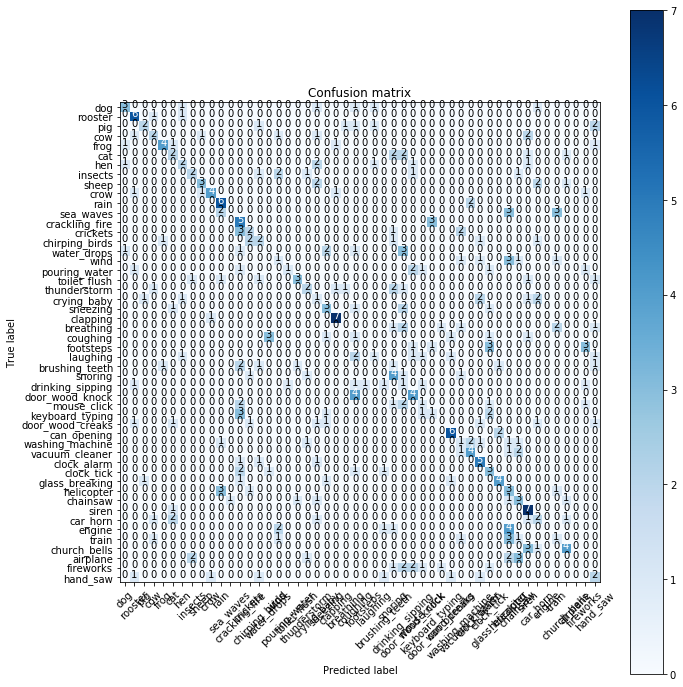

CPU times: user 1min, sys: 11.8 s, total: 1min 12s
Wall time: 10.8 s


In [15]:
%%time

pred = clas.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [16]:
%%time

import time
from load_blockwise import load_file_blockwise

predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = load_file_blockwise(dataset.iloc[data_iloc].filename,
                                 blocksize=orig_blocksize,
                                 overlap=orig_overlap)
    y_file = dataset.iloc[data_iloc].h_category
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clas.predict(x_file, verbose=0)
    pred_probs.append(clas.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
   
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))


	File Time: 0.1864769458770752
	File Time: 0.18165016174316406
	File Time: 0.17998361587524414
	File Time: 0.18689799308776855
	File Time: 0.2619009017944336
	File Time: 0.2611367702484131
	File Time: 0.22371912002563477
	File Time: 0.22832751274108887
	File Time: 0.26078033447265625
	File Time: 0.2656059265136719
	File Time: 0.2218494415283203
	File Time: 0.22054719924926758
	File Time: 0.26122593879699707
	File Time: 0.2616703510284424
	File Time: 0.26356959342956543
	File Time: 0.2585163116455078
	File Time: 0.25682663917541504
	File Time: 0.22005915641784668
	File Time: 0.26166844367980957
	File Time: 0.2653470039367676
	File Time: 0.25530385971069336
	File Time: 0.2282705307006836
	File Time: 0.22851920127868652
	File Time: 0.2609238624572754
	File Time: 0.25309062004089355
	File Time: 0.2479853630065918
	File Time: 0.25662946701049805
	File Time: 0.2219846248626709
	File Time: 0.2705237865447998
	File Time: 0.22638630867004395
	File Time: 0.22994565963745117
	File Time: 0.2705032

In [17]:
import numpy as np
targs = np.vstack(full_targets)

0.45
0.47713632416333107
Confusion matrix, without normalization
[[27  0  0 ...  0  0  0]
 [ 0 38  0 ...  0  0  0]
 [ 2  1 13 ...  0  0  2]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0 11  1]
 [ 1  1  1 ...  0  0 20]]


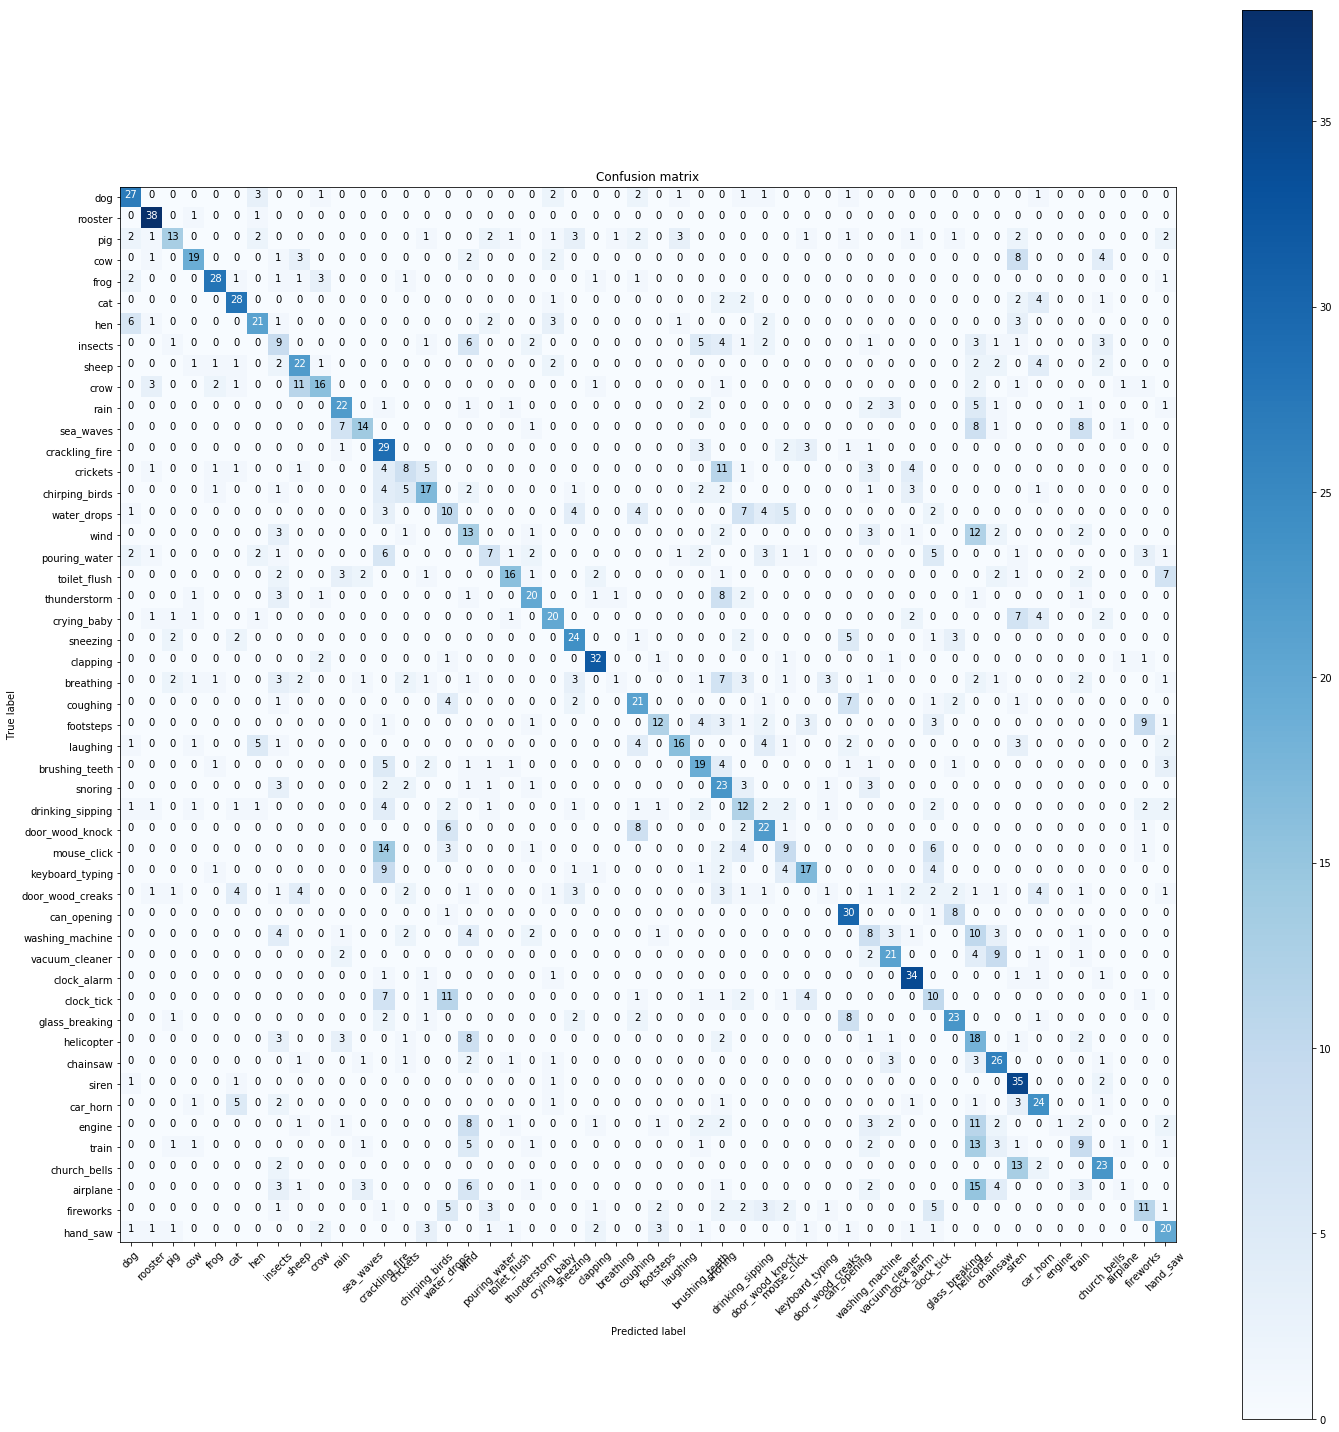

In [47]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [19]:
%%time
from sklearn.model_selection import cross_validate

clf = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

scores = cross_validate(clf, train_X, train_yy, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [20]:
clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_7 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                69664     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
__________

In [21]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,1582.100692,6.219577,0.250000,0.210425,0.264119,0.421875,0.439623,0.417526
1,2000.700007,11.154503,0.215625,0.213230,0.215000,0.481250,0.470150,0.471752
2,3882.243481,6.395681,0.240625,0.226087,0.264279,0.459375,0.499097,0.457725
3,1573.652666,6.461634,0.200000,0.174371,0.220083,0.480469,0.503843,0.472253
4,1548.288128,6.524832,0.271875,0.232254,0.246548,0.415625,0.440054,0.417587


In [41]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)
    
    predictions = []

    test = dataset[dataset.fold == 1]
    
    for data_iloc in range(0,len(test)):
        x_file = load_file_blockwise(test.iloc[data_iloc].filename,
                             blocksize=orig_blocksize,
                             overlap=orig_overlap)

        prob = clf.predict_proba(x_file)[0,l_l]
        pred = clf.predict(x_file)
        
        predictions.append({
            'file': test.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': prob,
            'prediction': pred
        })
        
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    return predictions

In [42]:
%%time
preds = query_dataset('dog')

CPU times: user 4min 17s, sys: 42.8 s, total: 5min
Wall time: 1min 35s


In [43]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
#     print(misclass)
    return (count - len(misclass))/count

In [44]:
# Checking index
check_accuracy(preds, 'dog', 10)

0.4

In [48]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

0.4
0.4
0.1
0.1
0.4
0.1
0.3
0.1
0.5
0.6
0.5
0.5
0.3
0.1
0.3
0.2
0.2
0.0
0.1
0.2
0.4
0.4
0.6
0.1
0.1
0.2
0.1
0.2
0.1
0.0
0.4
0.2
0.2
0.3
0.6
0.1
0.4
0.6
0.3
0.4
0.1
0.3
0.3
0.3
0.0
0.2
0.4
0.0
0.1
0.2


0.26